In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('Industrial_City_Case_Study.csv')

# Clean column names and convert data types
df.columns = [col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_per_') 
              for col in df.columns]

# Convert percentage columns to numeric
percentage_columns = ['Infrastructure_Readiness_%', 'Projected_Completion_2025_%', 
                     'Projected_ROI_2025_%', 'Projected_ROI_2030_%']

for col in percentage_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('%', ''), errors='coerce')

# Convert other numeric columns
numeric_columns = ['Water_Demand_m3_per_day', 'Avg_Compensation_Level_USD', 
                  'Total_Investment_2020-2023_USD_Million', 'Incentives_Granted_2020-2023_USD_Million',
                  'Current_GDP_Contribution_USD_Million', 'Projected_GDP_Contribution_2025_USD_Million',
                  'Projected_GDP_Contribution_2030_USD_Million', 'Projected_Employees_2030']

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

print("="*80)
print("INDUSTRIAL CITY DATA ANALYSIS - STRATEGIC INSIGHTS")
print("="*80)
#print(df.dtypes)

INDUSTRIAL CITY DATA ANALYSIS - STRATEGIC INSIGHTS


In [7]:
# =============================================================================
# QUESTION 1: UTILITY DEMAND vs CAPACITY ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("1. UTILITY DEMAND vs CAPACITY ANALYSIS")
print("="*60)

# Calculate capacity gaps
df['Capacity_Gap_2025'] = df['Projected_Demand_2025_MW'] - df['Current_Utility_Capacity_MW']
df['Capacity_Gap_2030'] = df['Projected_Demand_2030_MW'] - df['Current_Utility_Capacity_MW']
df['Capacity_Utilization_2025_%'] = (df['Projected_Demand_2025_MW'] / df['Current_Utility_Capacity_MW'] * 100).round(1)
df['Capacity_Utilization_2030_%'] = (df['Projected_Demand_2030_MW'] / df['Current_Utility_Capacity_MW'] * 100).round(1)

# Identify clusters with capacity shortfalls
critical_2025 = df[df['Capacity_Gap_2025'] > 0].copy()
critical_2030 = df[df['Capacity_Gap_2030'] > 0].copy()

print("1.1 CLUSTERS WITH UTILITY CAPACITY SHORTFALLS")
print("-" * 50)

print("CRITICAL CLUSTERS - 2025:")
if not critical_2025.empty:
    critical_2025_sorted = critical_2025.sort_values('Capacity_Gap_2025', ascending=False)
    print(f"{'Cluster':<8} {'Gap (MW)':<10} {'Utilization %':<15} {'Risk Level':<12}")
    print("-" * 50)
    for _, row in critical_2025_sorted.iterrows():
        risk_level = "CRITICAL" if row['Capacity_Utilization_2025_%'] > 120 else "HIGH" if row['Capacity_Utilization_2025_%'] > 110 else "MODERATE"
        print(f"{int(row['Cluster_ID']):<8} {row['Capacity_Gap_2025']:<10.0f} {row['Capacity_Utilization_2025_%']:<15.1f} {risk_level:<12}")
else:
    print("No capacity shortfalls projected for 2025")

print("\nCRITICAL CLUSTERS - 2030:")
if not critical_2030.empty:
    critical_2030_sorted = critical_2030.sort_values('Capacity_Gap_2030', ascending=False)
    print(f"{'Cluster':<8} {'Gap (MW)':<10} {'Utilization %':<15} {'Risk Level':<12}")
    print("-" * 50)
    for _, row in critical_2030_sorted.iterrows():
        risk_level = "CRITICAL" if row['Capacity_Utilization_2030_%'] > 120 else "HIGH" if row['Capacity_Utilization_2030_%'] > 110 else "MODERATE"
        print(f"{int(row['Cluster_ID']):<8} {row['Capacity_Gap_2030']:<10.0f} {row['Capacity_Utilization_2030_%']:<15.1f} {risk_level:<12}")
else:
    print("No capacity shortfalls projected for 2030")

# Mitigation strategies
print("\n1.2 MITIGATION STRATEGIES")
print("-" * 30)

total_gap_2025 = df['Capacity_Gap_2025'][df['Capacity_Gap_2025'] > 0].sum()
total_gap_2030 = df['Capacity_Gap_2030'][df['Capacity_Gap_2030'] > 0].sum()

print("IMMEDIATE ACTIONS (2025):")
print(f"• Total capacity shortfall: {total_gap_2025:.0f} MW")
print(f"• Estimated investment needed: ${total_gap_2025 * 1.5:.0f}M (at $1.5M/MW)")
print("• Priority clusters for capacity expansion:")

if not critical_2025.empty:
    for _, row in critical_2025_sorted.head(3).iterrows():
        print(f"  - Cluster {int(row['Cluster_ID'])}: +{row['Capacity_Gap_2025']:.0f} MW needed")

print(f"\nLONG-TERM PLANNING (2030):")
print(f"• Total capacity shortfall: {total_gap_2030:.0f} MW")
print(f"• Estimated investment needed: ${total_gap_2030 * 1.5:.0f}M")
print("• Recommended strategies:")
print("  - Phased capacity expansion (2025-2030)")
print("  - Demand management programs")
print("  - Alternative energy sources integration")
print("  - Smart grid implementation")


1. UTILITY DEMAND vs CAPACITY ANALYSIS
1.1 CLUSTERS WITH UTILITY CAPACITY SHORTFALLS
--------------------------------------------------
CRITICAL CLUSTERS - 2025:
Cluster  Gap (MW)   Utilization %   Risk Level  
--------------------------------------------------
2        20         125.0           CRITICAL    
5        20         122.2           CRITICAL    
7        20         120.0           HIGH        
9        20         123.5           CRITICAL    
10       20         126.7           CRITICAL    
4        15         121.4           CRITICAL    
1        10         116.7           HIGH        
3        10         120.0           HIGH        
6        10         115.4           HIGH        
8        10         118.2           HIGH        

CRITICAL CLUSTERS - 2030:
Cluster  Gap (MW)   Utilization %   Risk Level  
--------------------------------------------------
5        50         155.6           CRITICAL    
7        50         150.0           CRITICAL    
2        40         15

In [8]:
# =============================================================================
# QUESTION 2: GROWTH LEADERS IN JOBS AND GDP
# =============================================================================

print("\n" + "="*60)
print("2. GROWTH LEADERS ANALYSIS")
print("="*60)

# Calculate growth metrics
df['Job_Growth_2025_%'] = ((df['Projected_Employees_2025'] - df['Current_Employees']) / df['Current_Employees'] * 100).round(1)
df['Job_Growth_2030_%'] = ((df['Projected_Employees_2030'] - df['Current_Employees']) / df['Current_Employees'] * 100).round(1)
df['GDP_Growth_2025_%'] = ((df['Projected_GDP_Contribution_2025_USD_Million'] - df['Current_GDP_Contribution_USD_Million']) / df['Current_GDP_Contribution_USD_Million'] * 100).round(1)
df['GDP_Growth_2030_%'] = ((df['Projected_GDP_Contribution_2030_USD_Million'] - df['Current_GDP_Contribution_USD_Million']) / df['Current_GDP_Contribution_USD_Million'] * 100).round(1)

df['Job_Growth_Absolute_2025'] = df['Projected_Employees_2025'] - df['Current_Employees']
df['Job_Growth_Absolute_2030'] = df['Projected_Employees_2030'] - df['Current_Employees']
df['GDP_Growth_Absolute_2025'] = df['Projected_GDP_Contribution_2025_USD_Million'] - df['Current_GDP_Contribution_USD_Million']
df['GDP_Growth_Absolute_2030'] = df['Projected_GDP_Contribution_2030_USD_Million'] - df['Current_GDP_Contribution_USD_Million']

print("2.1 JOB CREATION LEADERS")
print("-" * 30)

job_leaders_2025 = df.nlargest(5, 'Job_Growth_Absolute_2025')[['Cluster_ID', 'Job_Growth_Absolute_2025', 'Job_Growth_2025_%', 'Current_Employees', 'Projected_Employees_2025']]
job_leaders_2030 = df.nlargest(5, 'Job_Growth_Absolute_2030')[['Cluster_ID', 'Job_Growth_Absolute_2030', 'Job_Growth_2030_%', 'Current_Employees', 'Projected_Employees_2030']]

print("TOP JOB CREATORS (2025):")
print(f"{'Cluster':<8} {'New Jobs':<10} {'Growth %':<10} {'Current':<10} {'Projected':<10}")
print("-" * 55)
for _, row in job_leaders_2025.iterrows():
    print(f"{int(row['Cluster_ID']):<8} {row['Job_Growth_Absolute_2025']:<10.0f} {row['Job_Growth_2025_%']:<10.1f} {row['Current_Employees']:<10.0f} {row['Projected_Employees_2025']:<10.0f}")

print("\nTOP JOB CREATORS (2030):")
print(f"{'Cluster':<8} {'New Jobs':<10} {'Growth %':<10} {'Current':<10} {'Projected':<10}")
print("-" * 55)
for _, row in job_leaders_2030.iterrows():
    print(f"{int(row['Cluster_ID']):<8} {row['Job_Growth_Absolute_2030']:<10.0f} {row['Job_Growth_2030_%']:<10.1f} {row['Current_Employees']:<10.0f} {row['Projected_Employees_2030']:<10.0f}")

print("\n2.2 GDP CONTRIBUTION LEADERS")
print("-" * 35)

gdp_leaders_2025 = df.nlargest(5, 'GDP_Growth_Absolute_2025')[['Cluster_ID', 'GDP_Growth_Absolute_2025', 'GDP_Growth_2025_%', 'Current_GDP_Contribution_USD_Million', 'Projected_GDP_Contribution_2025_USD_Million']]
gdp_leaders_2030 = df.nlargest(5, 'GDP_Growth_Absolute_2030')[['Cluster_ID', 'GDP_Growth_Absolute_2030', 'GDP_Growth_2030_%', 'Current_GDP_Contribution_USD_Million', 'Projected_GDP_Contribution_2030_USD_Million']]

print("TOP GDP CONTRIBUTORS (2025):")
print(f"{'Cluster':<8} {'GDP Growth (M)':<15} {'Growth %':<10} {'Current (M)':<12} {'Projected (M)':<15}")
print("-" * 65)
for _, row in gdp_leaders_2025.iterrows():
    print(f"{int(row['Cluster_ID']):<8} {row['GDP_Growth_Absolute_2025']:<15.0f} {row['GDP_Growth_2025_%']:<10.1f} {row['Current_GDP_Contribution_USD_Million']:<12.0f} {row['Projected_GDP_Contribution_2025_USD_Million']:<15.0f}")

print("\nTOP GDP CONTRIBUTORS (2030):")
print(f"{'Cluster':<8} {'GDP Growth (M)':<15} {'Growth %':<10} {'Current (M)':<12} {'Projected (M)':<15}")
print("-" * 65)
for _, row in gdp_leaders_2030.iterrows():
    print(f"{int(row['Cluster_ID']):<8} {row['GDP_Growth_Absolute_2030']:<15.0f} {row['GDP_Growth_2030_%']:<10.1f} {row['Current_GDP_Contribution_USD_Million']:<12.0f} {row['Projected_GDP_Contribution_2030_USD_Million']:<15.0f}")


2. GROWTH LEADERS ANALYSIS
2.1 JOB CREATION LEADERS
------------------------------
TOP JOB CREATORS (2025):
Cluster  New Jobs   Growth %   Current    Projected 
-------------------------------------------------------
9        180        42.9       420        600       
10       180        34.6       520        700       
2        150        37.5       400        550       
3        150        42.9       350        500       
4        150        33.3       450        600       

TOP JOB CREATORS (2030):
Cluster  New Jobs   Growth %   Current    Projected 
-------------------------------------------------------
10       480        92.3       520        1000      
9        430        102.4      420        850       
4        400        88.9       450        850       
7        400        50.0       800        1200      
6        380        118.8      320        700       

2.2 GDP CONTRIBUTION LEADERS
-----------------------------------
TOP GDP CONTRIBUTORS (2025):
Cluster  GDP Growth (M

In [9]:
# =============================================================================
# QUESTION 3: ROI ANALYSIS ON INVESTMENTS AND INCENTIVES
# =============================================================================

print("\n" + "="*60)
print("3. ROI ANALYSIS ON INVESTMENTS AND INCENTIVES")
print("="*60)

# Calculate ROI efficiency metrics
df['Investment_per_Employee'] = df['Total_Investment_2020-2023_USD_Million'] / df['Current_Employees'] * 1000  # per employee in thousands
df['Incentive_per_Employee'] = df['Incentives_Granted_2020-2023_USD_Million'] / df['Current_Employees'] * 1000
df['GDP_ROI_2025'] = df['GDP_Growth_Absolute_2025'] / df['Total_Investment_2020-2023_USD_Million']
df['GDP_ROI_2030'] = df['GDP_Growth_Absolute_2030'] / df['Total_Investment_2020-2023_USD_Million']
df['Incentive_Efficiency_2025'] = df['GDP_Growth_Absolute_2025'] / df['Incentives_Granted_2020-2023_USD_Million']
df['Incentive_Efficiency_2030'] = df['GDP_Growth_Absolute_2030'] / df['Incentives_Granted_2020-2023_USD_Million']

print("3.1 HIGHEST ROI CLUSTERS")
print("-" * 30)

roi_leaders = df.nlargest(5, 'Projected_ROI_2025_%')[['Cluster_ID', 'Projected_ROI_2025_%', 'Projected_ROI_2030_%', 'GDP_ROI_2025', 'Incentive_Efficiency_2025']]

print("TOP ROI PERFORMERS (2025):")
print(f"{'Cluster':<8} {'ROI 2025%':<12} {'ROI 2030%':<12} {'GDP/Invest':<12} {'GDP/Incentive':<15}")
print("-" * 65)
for _, row in roi_leaders.iterrows():
    print(f"{int(row['Cluster_ID']):<8} {row['Projected_ROI_2025_%']:<12.1f} {row['Projected_ROI_2030_%']:<12.1f} {row['GDP_ROI_2025']:<12.2f} {row['Incentive_Efficiency_2025']:<15.2f}")

print("\n3.2 LOWEST ROI CLUSTERS (REQUIRING ATTENTION)")
print("-" * 50)

roi_laggards = df.nsmallest(5, 'Projected_ROI_2025_%')[['Cluster_ID', 'Projected_ROI_2025_%', 'Projected_ROI_2030_%', 'GDP_ROI_2025', 'Incentive_Efficiency_2025', 'Infrastructure_Readiness_%']]

print("UNDERPERFORMING CLUSTERS:")
print(f"{'Cluster':<8} {'ROI 2025%':<12} {'ROI 2030%':<12} {'GDP/Invest':<12} {'Infrastructure%':<15}")
print("-" * 65)
for _, row in roi_laggards.iterrows():
    print(f"{int(row['Cluster_ID']):<8} {row['Projected_ROI_2025_%']:<12.1f} {row['Projected_ROI_2030_%']:<12.1f} {row['GDP_ROI_2025']:<12.2f} {row['Infrastructure_Readiness_%']:<15.0f}")

print("\n3.3 INVESTMENT EFFICIENCY ANALYSIS")
print("-" * 40)

# Calculate summary statistics
avg_roi_2025 = df['Projected_ROI_2025_%'].mean()
avg_roi_2030 = df['Projected_ROI_2030_%'].mean()
total_investment = df['Total_Investment_2020-2023_USD_Million'].sum()
total_incentives = df['Incentives_Granted_2020-2023_USD_Million'].sum()
total_gdp_growth_2025 = df['GDP_Growth_Absolute_2025'].sum()

print(f"OVERALL PERFORMANCE METRICS:")
print(f"• Average ROI 2025: {avg_roi_2025:.1f}%")
print(f"• Average ROI 2030: {avg_roi_2030:.1f}%")
print(f"• Total Investment: ${total_investment:.0f}M")
print(f"• Total Incentives: ${total_incentives:.0f}M")
print(f"• Expected GDP Growth (2025): ${total_gdp_growth_2025:.0f}M")
print(f"• Overall Investment ROI: {total_gdp_growth_2025/total_investment:.2f}x")
print(f"• Incentive Efficiency: ${total_gdp_growth_2025/total_incentives:.2f} GDP per $1 incentive")



3. ROI ANALYSIS ON INVESTMENTS AND INCENTIVES
3.1 HIGHEST ROI CLUSTERS
------------------------------
TOP ROI PERFORMERS (2025):
Cluster  ROI 2025%    ROI 2030%    GDP/Invest   GDP/Incentive  
-----------------------------------------------------------------
7        20.0         30.0         0.43         2.73           
5        18.0         28.0         0.42         2.50           
10       17.0         27.0         0.38         2.22           
9        16.0         26.0         0.42         2.53           
1        15.0         25.0         0.67         4.00           

3.2 LOWEST ROI CLUSTERS (REQUIRING ATTENTION)
--------------------------------------------------
UNDERPERFORMING CLUSTERS:
Cluster  ROI 2025%    ROI 2030%    GDP/Invest   Infrastructure%
-----------------------------------------------------------------
4        10.0         20.0         0.50         65             
8        11.0         21.0         0.82         72             
2        12.0         22.0         0.4

In [10]:
# =============================================================================
# QUESTION 4: INFRASTRUCTURE vs INVESTMENT CROSS-ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("4. INFRASTRUCTURE vs INVESTMENT CROSS-ANALYSIS")
print("="*60)

# Create investment adequacy assessment
df['Investment_per_km2'] = df['Total_Investment_2020-2023_USD_Million'] / df['Total_Land_Area_km2']
df['Investment_Intensity'] = pd.cut(df['Investment_per_km2'], bins=3, labels=['Low', 'Medium', 'High'])
df['Infrastructure_Category'] = pd.cut(df['Infrastructure_Readiness_%'], bins=[0, 70, 85, 100], labels=['Behind', 'On-Track', 'Advanced'])

# Calculate completion risk
df['Completion_Risk'] = 100 - df['Projected_Completion_2025_%']
df['Investment_Gap_Indicator'] = np.where(
    (df['Infrastructure_Readiness_%'] < 80) & (df['Investment_per_km2'] < df['Investment_per_km2'].median()),
    'HIGH RISK', 
    np.where(
        (df['Infrastructure_Readiness_%'] < 85) | (df['Investment_per_km2'] < df['Investment_per_km2'].median()),
        'MEDIUM RISK',
        'LOW RISK'
    )
)

print("4.1 INFRASTRUCTURE READINESS vs INVESTMENT LEVELS")
print("-" * 55)

print(f"{'Cluster':<8} {'Infrastructure%':<15} {'Investment/km2':<15} {'Completion%':<12} {'Risk Level':<12}")
print("-" * 70)
for _, row in df.iterrows():
    print(f"{int(row['Cluster_ID']):<8} {row['Infrastructure_Readiness_%']:<15.0f} {row['Investment_per_km2']:<15.1f} {row['Projected_Completion_2025_%']:<12.0f} {row['Investment_Gap_Indicator']:<12}")

print("\n4.2 CLUSTERS REQUIRING ADDITIONAL INVESTMENT")
print("-" * 50)

high_risk_clusters = df[df['Investment_Gap_Indicator'] == 'HIGH RISK'].copy()
medium_risk_clusters = df[df['Investment_Gap_Indicator'] == 'MEDIUM RISK'].copy()

if not high_risk_clusters.empty:
    print("HIGH RISK CLUSTERS (Immediate Attention Required):")
    for _, row in high_risk_clusters.iterrows():
        additional_investment = (df['Investment_per_km2'].median() - row['Investment_per_km2']) * row['Total_Land_Area_km2']
        print(f"• Cluster {int(row['Cluster_ID'])}: Infrastructure {row['Infrastructure_Readiness_%']:.0f}%, needs ~${additional_investment:.0f}M additional investment")

if not medium_risk_clusters.empty:
    print(f"\nMEDIUM RISK CLUSTERS (Monitor Closely):")
    for _, row in medium_risk_clusters.iterrows():
        print(f"• Cluster {int(row['Cluster_ID'])}: Infrastructure {row['Infrastructure_Readiness_%']:.0f}%, completion {row['Projected_Completion_2025_%']:.0f}%")

print("\n4.3 INVESTMENT RECOMMENDATIONS")
print("-" * 40)

total_additional_needed = 0
if not high_risk_clusters.empty:
    for _, row in high_risk_clusters.iterrows():
        additional = (df['Investment_per_km2'].median() - row['Investment_per_km2']) * row['Total_Land_Area_km2']
        if additional > 0:
            total_additional_needed += additional

print("STRATEGIC RECOMMENDATIONS:")
print(f"• Total additional investment needed: ${total_additional_needed:.0f}M")
print(f"• Focus on {len(high_risk_clusters)} high-risk clusters")
print(f"• Prioritize infrastructure development over expansion")
print("• Implement milestone-based investment releases")
print("• Consider public-private partnerships for large investments")


4. INFRASTRUCTURE vs INVESTMENT CROSS-ANALYSIS
4.1 INFRASTRUCTURE READINESS vs INVESTMENT LEVELS
-------------------------------------------------------
Cluster  Infrastructure% Investment/km2  Completion%  Risk Level  
----------------------------------------------------------------------
1        80              30.0            95           MEDIUM RISK 
2        70              33.3            85           MEDIUM RISK 
3        75              20.8            90           HIGH RISK   
4        65              50.0            80           MEDIUM RISK 
5        85              33.3            98           LOW RISK    
6        78              25.0            92           HIGH RISK   
7        90              35.0            99           LOW RISK    
8        72              20.0            88           HIGH RISK   
9        82              34.6            96           MEDIUM RISK 
10       88              32.5            97           MEDIUM RISK 

4.2 CLUSTERS REQUIRING ADDITIONAL INV


GENERATING COMPREHENSIVE ANALYSIS DASHBOARD


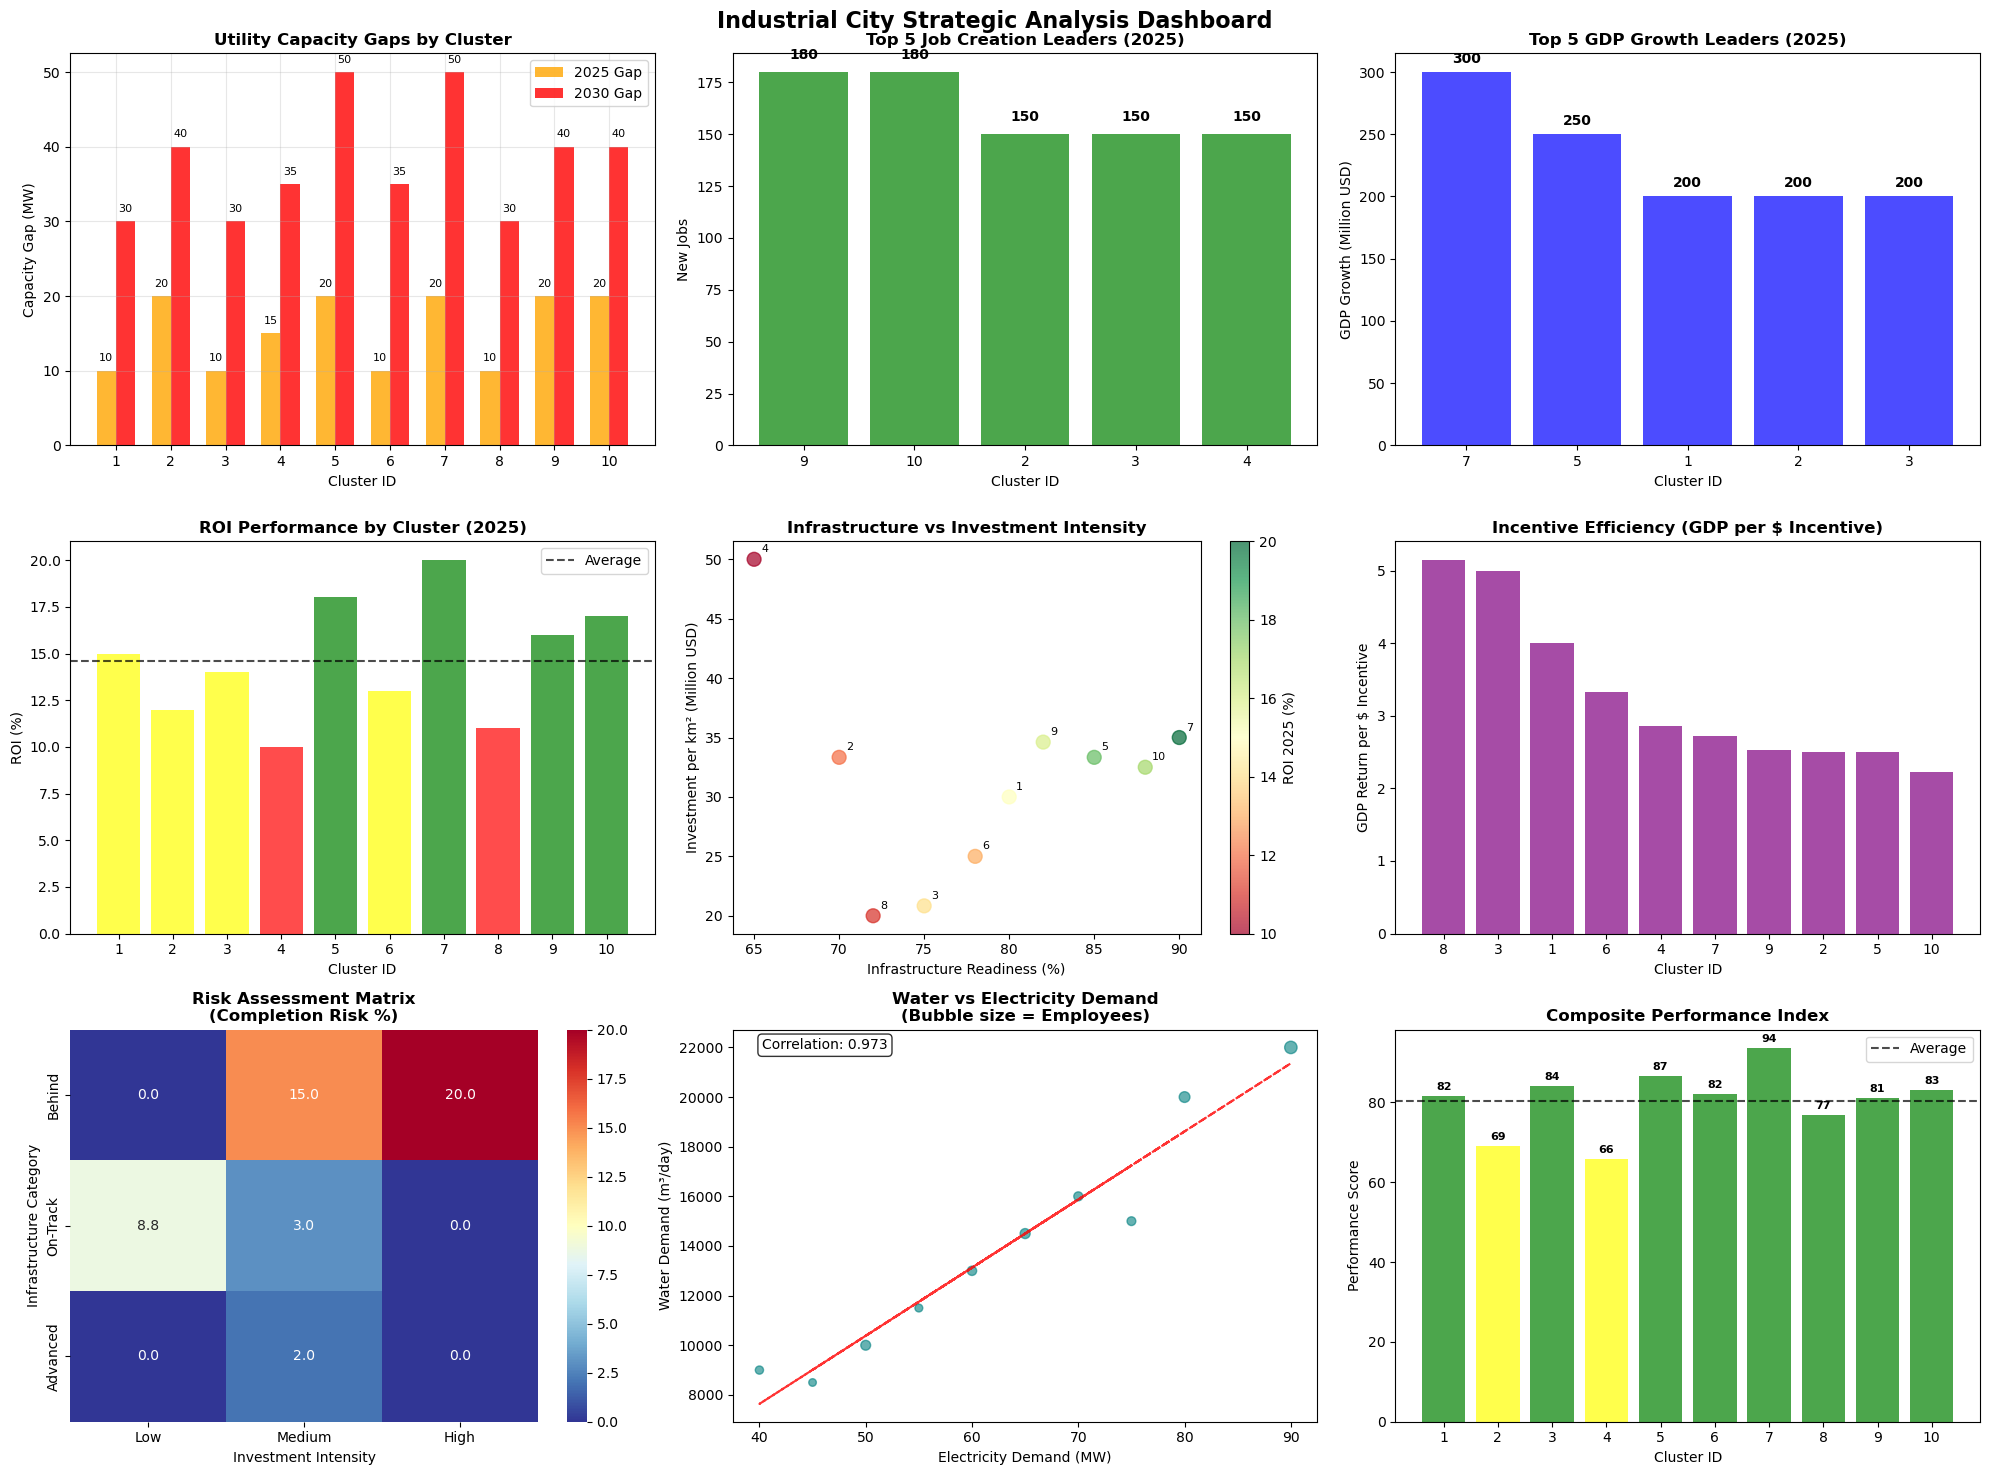

In [13]:
# =============================================================================
# COMPREHENSIVE VISUALIZATION DASHBOARD
# =============================================================================

print("\n" + "="*60)
print("GENERATING COMPREHENSIVE ANALYSIS DASHBOARD")
print("="*60)

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Industrial City Strategic Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Capacity Gap Analysis
ax1 = axes[0, 0]
clusters = df['Cluster_ID']
gaps_2025 = df['Capacity_Gap_2025']
gaps_2030 = df['Capacity_Gap_2030']

x = np.arange(len(clusters))
width = 0.35

bars1 = ax1.bar(x - width/2, gaps_2025, width, label='2025 Gap', alpha=0.8, color='orange')
bars2 = ax1.bar(x + width/2, gaps_2030, width, label='2030 Gap', alpha=0.8, color='red')

ax1.set_title('Utility Capacity Gaps by Cluster', fontweight='bold')
ax1.set_xlabel('Cluster ID')
ax1.set_ylabel('Capacity Gap (MW)')
ax1.set_xticks(x)
ax1.set_xticklabels(clusters)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1, f'{int(height)}', 
                ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1, f'{int(height)}', 
                ha='center', va='bottom', fontsize=8)

# 2. Job Growth Leaders
ax2 = axes[0, 1]
job_growth_data = df.nlargest(5, 'Job_Growth_Absolute_2025')
bars = ax2.bar(job_growth_data['Cluster_ID'].astype(str), job_growth_data['Job_Growth_Absolute_2025'], 
               color='green', alpha=0.7)
ax2.set_title('Top 5 Job Creation Leaders (2025)', fontweight='bold')
ax2.set_xlabel('Cluster ID')
ax2.set_ylabel('New Jobs')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5, f'{int(height)}', 
             ha='center', va='bottom', fontweight='bold')

# 3. GDP Growth Leaders
ax3 = axes[0, 2]
gdp_growth_data = df.nlargest(5, 'GDP_Growth_Absolute_2025')
bars = ax3.bar(gdp_growth_data['Cluster_ID'].astype(str), gdp_growth_data['GDP_Growth_Absolute_2025'], 
               color='blue', alpha=0.7)
ax3.set_title('Top 5 GDP Growth Leaders (2025)', fontweight='bold')
ax3.set_xlabel('Cluster ID')
ax3.set_ylabel('GDP Growth (Million USD)')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 5, f'{int(height)}', 
             ha='center', va='bottom', fontweight='bold')

# 4. ROI Performance
ax4 = axes[1, 0]
roi_colors = ['red' if x < 12 else 'yellow' if x < 16 else 'green' for x in df['Projected_ROI_2025_%']]
bars = ax4.bar(df['Cluster_ID'].astype(str), df['Projected_ROI_2025_%'], color=roi_colors, alpha=0.7)
ax4.set_title('ROI Performance by Cluster (2025)', fontweight='bold')
ax4.set_xlabel('Cluster ID')
ax4.set_ylabel('ROI (%)')
ax4.axhline(y=df['Projected_ROI_2025_%'].mean(), color='black', linestyle='--', alpha=0.7, label='Average')
ax4.legend()

# 5. Infrastructure vs Investment Scatter
ax5 = axes[1, 1]
colors = df['Projected_ROI_2025_%']
scatter = ax5.scatter(df['Infrastructure_Readiness_%'], df['Investment_per_km2'], 
                     c=colors, cmap='RdYlGn', s=100, alpha=0.7)
ax5.set_title('Infrastructure vs Investment Intensity', fontweight='bold')
ax5.set_xlabel('Infrastructure Readiness (%)')
ax5.set_ylabel('Investment per km² (Million USD)')
plt.colorbar(scatter, ax=ax5, label='ROI 2025 (%)')

# Add cluster labels
for i, row in df.iterrows():
    ax5.annotate(f"{int(row['Cluster_ID'])}", 
                (row['Infrastructure_Readiness_%'], row['Investment_per_km2']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 6. Investment Efficiency
ax6 = axes[1, 2]
efficiency_data = df.sort_values('Incentive_Efficiency_2025', ascending=False)
bars = ax6.bar(efficiency_data['Cluster_ID'].astype(str), efficiency_data['Incentive_Efficiency_2025'], 
               color='purple', alpha=0.7)
ax6.set_title('Incentive Efficiency (GDP per $ Incentive)', fontweight='bold')
ax6.set_xlabel('Cluster ID')
ax6.set_ylabel('GDP Return per $ Incentive')

#7. Risk Assessment Matrix
ax7 = axes[2, 0]
risk_matrix = df.pivot_table(values='Completion_Risk', 
                           index='Infrastructure_Category', 
                           columns='Investment_Intensity',
                           aggfunc='mean', fill_value=0)

# Create heatmap for risk assessment
sns.heatmap(risk_matrix, annot=True, cmap='RdYlBu_r', ax=ax7, fmt='.1f')
ax7.set_title('Risk Assessment Matrix\n(Completion Risk %)', fontweight='bold')
ax7.set_xlabel('Investment Intensity')
ax7.set_ylabel('Infrastructure Category')

# 8. Water vs Electricity Demand Correlation
ax8 = axes[2, 1]
ax8.scatter(df['Electricity_Demand_MW'], df['Water_Demand_m3_per_day'], 
           s=df['Current_Employees']/10, alpha=0.6, c='teal')
ax8.set_title('Water vs Electricity Demand\n(Bubble size = Employees)', fontweight='bold')
ax8.set_xlabel('Electricity Demand (MW)')
ax8.set_ylabel('Water Demand (m³/day)')

# Add trend line
z = np.polyfit(df['Electricity_Demand_MW'], df['Water_Demand_m3_per_day'], 1)
p = np.poly1d(z)
ax8.plot(df['Electricity_Demand_MW'], p(df['Electricity_Demand_MW']), "r--", alpha=0.8)

# Add correlation coefficient
correlation = df['Electricity_Demand_MW'].corr(df['Water_Demand_m3_per_day'])
ax8.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax8.transAxes, 
         bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

# 9. Comprehensive Performance Index
ax9 = axes[2, 2]
# Create composite performance score
df['Performance_Score'] = (
    (df['Projected_ROI_2025_%'] / df['Projected_ROI_2025_%'].max()) * 0.3 +
    (df['GDP_Growth_2025_%'] / df['GDP_Growth_2025_%'].max()) * 0.3 +
    (df['Infrastructure_Readiness_%'] / 100) * 0.2 +
    ((100 - df['Completion_Risk']) / 100) * 0.2
) * 100

performance_colors = ['red' if x < 60 else 'yellow' if x < 75 else 'green' for x in df['Performance_Score']]
bars = ax9.bar(df['Cluster_ID'].astype(str), df['Performance_Score'], color=performance_colors, alpha=0.7)
ax9.set_title('Composite Performance Index', fontweight='bold')
ax9.set_xlabel('Cluster ID')
ax9.set_ylabel('Performance Score')
ax9.axhline(y=df['Performance_Score'].mean(), color='black', linestyle='--', alpha=0.7, label='Average')
ax9.legend()

# Add performance scores on bars
for bar in bars:
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.0f}', 
             ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [14]:
# =============================================================================
# STRATEGIC RECOMMENDATIONS SUMMARY
# =============================================================================

print("\n" + "="*80)
print("STRATEGIC RECOMMENDATIONS SUMMARY")
print("="*80)

# Identify top performers and underperformers
top_performers = df.nlargest(3, 'Performance_Score')
underperformers = df.nsmallest(3, 'Performance_Score')

print("\n🏆 TOP PERFORMING CLUSTERS:")
print("-" * 40)
for _, cluster in top_performers.iterrows():
    print(f"Cluster {int(cluster['Cluster_ID'])}: Performance Score {cluster['Performance_Score']:.0f}")
    print(f"  • ROI 2025: {cluster['Projected_ROI_2025_%']:.1f}%")
    print(f"  • GDP Growth: {cluster['GDP_Growth_2025_%']:.1f}%")
    print(f"  • Infrastructure: {cluster['Infrastructure_Readiness_%']:.0f}%")
    print(f"  • Status: {cluster['Investment_Gap_Indicator']}")
    print()

print("⚠️  UNDERPERFORMING CLUSTERS (Requiring Intervention):")
print("-" * 55)
for _, cluster in underperformers.iterrows():
    print(f"Cluster {int(cluster['Cluster_ID'])}: Performance Score {cluster['Performance_Score']:.0f}")
    print(f"  • ROI 2025: {cluster['Projected_ROI_2025_%']:.1f}%")
    print(f"  • Infrastructure: {cluster['Infrastructure_Readiness_%']:.0f}%")
    print(f"  • Risk Level: {cluster['Investment_Gap_Indicator']}")
    print(f"  • Completion Risk: {cluster['Completion_Risk']:.0f}%")
    
    # Specific recommendations
    recommendations = []
    if cluster['Infrastructure_Readiness_%'] < 75:
        recommendations.append("Accelerate infrastructure development")
    if cluster['Projected_ROI_2025_%'] < 12:
        recommendations.append("Review business model and efficiency")
    if cluster['Investment_Gap_Indicator'] == 'HIGH RISK':
        recommendations.append("Increase investment allocation")
    if cluster['Completion_Risk'] > 15:
        recommendations.append("Implement stricter project management")
    
    if recommendations:
        print(f"  • Recommendations: {', '.join(recommendations)}")
    print()

print("📊 KEY PERFORMANCE INSIGHTS:")
print("-" * 35)
print(f"• Average Performance Score: {df['Performance_Score'].mean():.1f}")
print(f"• Performance Range: {df['Performance_Score'].min():.1f} - {df['Performance_Score'].max():.1f}")
print(f"• Clusters above average: {len(df[df['Performance_Score'] > df['Performance_Score'].mean()])}/10")
print(f"• High-risk clusters: {len(df[df['Investment_Gap_Indicator'] == 'HIGH RISK'])}/10")
print(f"• Clusters with capacity shortfalls (2025): {len(df[df['Capacity_Gap_2025'] > 0])}/10")

print(f"\n💰 FINANCIAL SUMMARY:")
print("-" * 25)
print(f"• Total investments (2020-2023): ${df['Total_Investment_2020-2023_USD_Million'].sum():.0f}M")
print(f"• Total incentives granted: ${df['Incentives_Granted_2020-2023_USD_Million'].sum():.0f}M")
print(f"• Expected GDP growth (2025): ${df['GDP_Growth_Absolute_2025'].sum():.0f}M")
print(f"• Overall investment ROI: {df['GDP_Growth_Absolute_2025'].sum()/df['Total_Investment_2020-2023_USD_Million'].sum():.2f}x")
print(f"• Additional investment needed: ${total_additional_needed:.0f}M")

print(f"\n🎯 PRIORITY ACTIONS:")
print("-" * 25)
print("1. IMMEDIATE (Next 6 months):")
print("   • Address capacity shortfalls in critical clusters")
print("   • Accelerate infrastructure development in high-risk areas")
print("   • Implement enhanced monitoring for underperforming clusters")

print("\n2. SHORT-TERM (6-18 months):")
print("   • Begin capacity expansion projects")
print("   • Launch efficiency improvement programs")
print("   • Establish milestone-based investment releases")

print("\n3. LONG-TERM (18+ months):")
print("   • Complete infrastructure development projects")
print("   • Evaluate and optimize investment strategies")
print("   • Plan for 2030 capacity requirements")

print("\n" + "="*80)
print("END OF ANALYSIS")
print("="*80)


STRATEGIC RECOMMENDATIONS SUMMARY

🏆 TOP PERFORMING CLUSTERS:
----------------------------------------
Cluster 7: Performance Score 94
  • ROI 2025: 20.0%
  • GDP Growth: 42.9%
  • Infrastructure: 90%
  • Status: LOW RISK

Cluster 5: Performance Score 87
  • ROI 2025: 18.0%
  • GDP Growth: 38.5%
  • Infrastructure: 85%
  • Status: LOW RISK

Cluster 3: Performance Score 84
  • ROI 2025: 14.0%
  • GDP Growth: 50.0%
  • Infrastructure: 75%
  • Status: HIGH RISK

⚠️  UNDERPERFORMING CLUSTERS (Requiring Intervention):
-------------------------------------------------------
Cluster 4: Performance Score 66
  • ROI 2025: 10.0%
  • Infrastructure: 65%
  • Risk Level: MEDIUM RISK
  • Completion Risk: 20%
  • Recommendations: Accelerate infrastructure development, Review business model and efficiency, Implement stricter project management

Cluster 2: Performance Score 69
  • ROI 2025: 12.0%
  • Infrastructure: 70%
  • Risk Level: MEDIUM RISK
  • Completion Risk: 15%
  • Recommendations: Accelera